# Import des données

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', 500)

In [3]:
X_train = pd.read_csv("X_train.csv", index_col=0, error_bad_lines=False)
X_test = pd.read_csv("X_test.csv", index_col=0, error_bad_lines=False)
y_train = pd.read_csv("y_train.csv", index_col=0)

b'Skipping line 2168: expected 31 fields, saw 33\nSkipping line 4822: expected 31 fields, saw 37\nSkipping line 4859: expected 31 fields, saw 37\nSkipping line 7342: expected 31 fields, saw 37\n'


In [4]:
print("Dimension X_train:", X_train.shape)
print("Dimension X_test:", X_test.shape)

Dimension X_train: (8880, 30)
Dimension X_test: (2960, 30)


In [5]:
X_train.head(3)

,nb_images,longueur_image,largeur_image,url_image,description_produit,taille,matiere,age,garantie,annee,couleur,largeur_produit,wifi,etat,longueur_produit,pointure,vintage,marque,auteur,editions,hauteur_produit,poids,prix,categorie,sous_categorie_1,sous_categorie_2,sous_categorie_3,sous_categorie_4,nom_produit,nom_magasin
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3,3458.0,2552.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,Superbe petit top bustier avec explosion de co...,44,100 % polyester,NaN,NaN,NaN,Multicolore,NaN,NaN,bon état,NaN,NaN,False,NaN,NaN,NaN,NaN,200.0,4.5,mode,"tops, t-shirts, débardeurs femme",NaN,NaN,NaN,Top bustier multicolore,Emmaüs 88 Neufchateau
1,2,2486.0,2254.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,"Radio ITT Océnic Flirt, année 70\nPour déco",NaN,Plastique,NaN,NaN,NaN,Jaune,NaN,NaN,en l'état,NaN,NaN,True,ITT Océanic,NaN,NaN,NaN,1000.0,15.0,mobilier - deco,bibelots et objets déco,NaN,NaN,NaN,Radio ITT Océanic,Communauté Emmaüs Thouars (magasin Parthenay)
2,3,1536.0,1536.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,Veste boléro à manches courtes NÛMPH. Gris chi...,40,"Polyester, coton, laine",NaN,NaN,NaN,Gris,NaN,NaN,neuf,NaN,NaN,False,Nûmph,NaN,NaN,NaN,360.0,16.0,label selection,mode,mode femme,NaN,NaN,NaN,Label Emmaüs Chambéry


Le dataset train comporte les caractéristiques et délai de vente de **8880 objets** vendus sur le site Emmaus. Chaque objet est décrit par une observation de X variables. Ces variables sont décrites dans le fichier ```description.pdf```.

Le dataset test comporte les caractéristiques des **2960 objets** dont il faut prédire le délai de vente.

# Classification des variables

In [6]:
to_be_drop_features = ['url_image']

binary_and_ordinal_features = ['taille',
                               'age',
                               'etat',
                               'garantie']

categorical_features = ['couleur',
                        'marque',
                        'auteur',
                        'editions',
                        'categorie',
                        'sous_categorie_1',
                        'sous_categorie_2',
                        'sous_categorie_3',
                        'sous_categorie_4',
                        'nom_magasin',
                        'wifi',
                        'vintage']

text_features = ['matiere',
                 'description_produit',
                 'nom_produit']

# Distribution des donnees

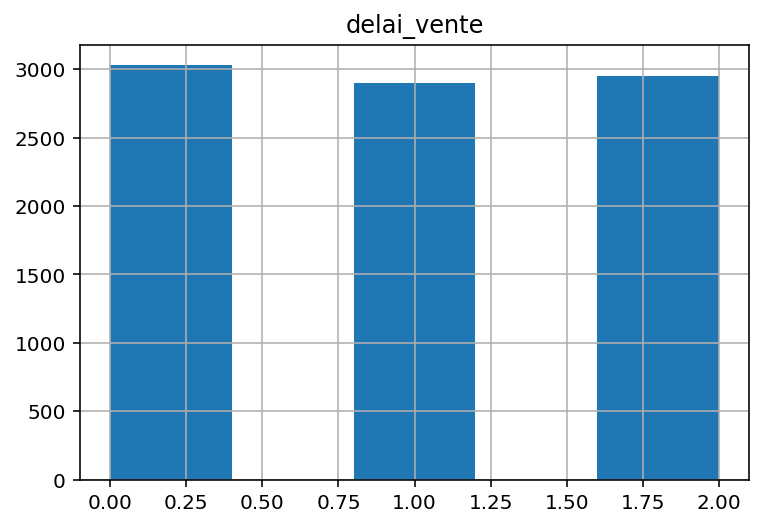

In [7]:
# Le jeu de données est très équilibré, chacune des 3 classes a une fréquence proche d’1/3.
y_train.hist(bins=5);

In [8]:
def compare_distribution(col):
    print(X_train[col].describe())
    bins = np.linspace(min(X_train[col]), max(X_train[col]), 30)
    plt.hist(X_train[col].dropna(), bins, alpha=0.5, label='train')
    plt.hist(X_test[col].dropna(), bins, alpha=0.5, label='test')
    plt.title(f'Distribution de {col}')
    plt.legend(loc='upper right')
    plt.show()

count    8880.000000
mean        3.633446
std         2.048567
min         0.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        29.000000
Name: nb_images, dtype: float64


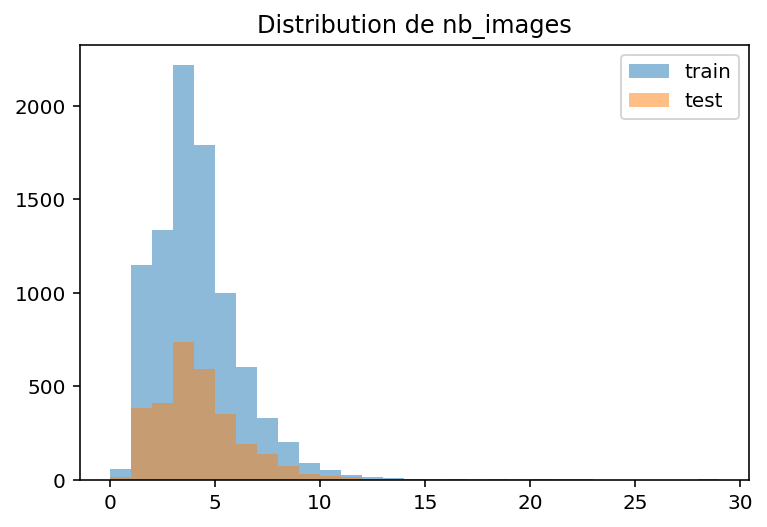

In [9]:
compare_distribution('nb_images')

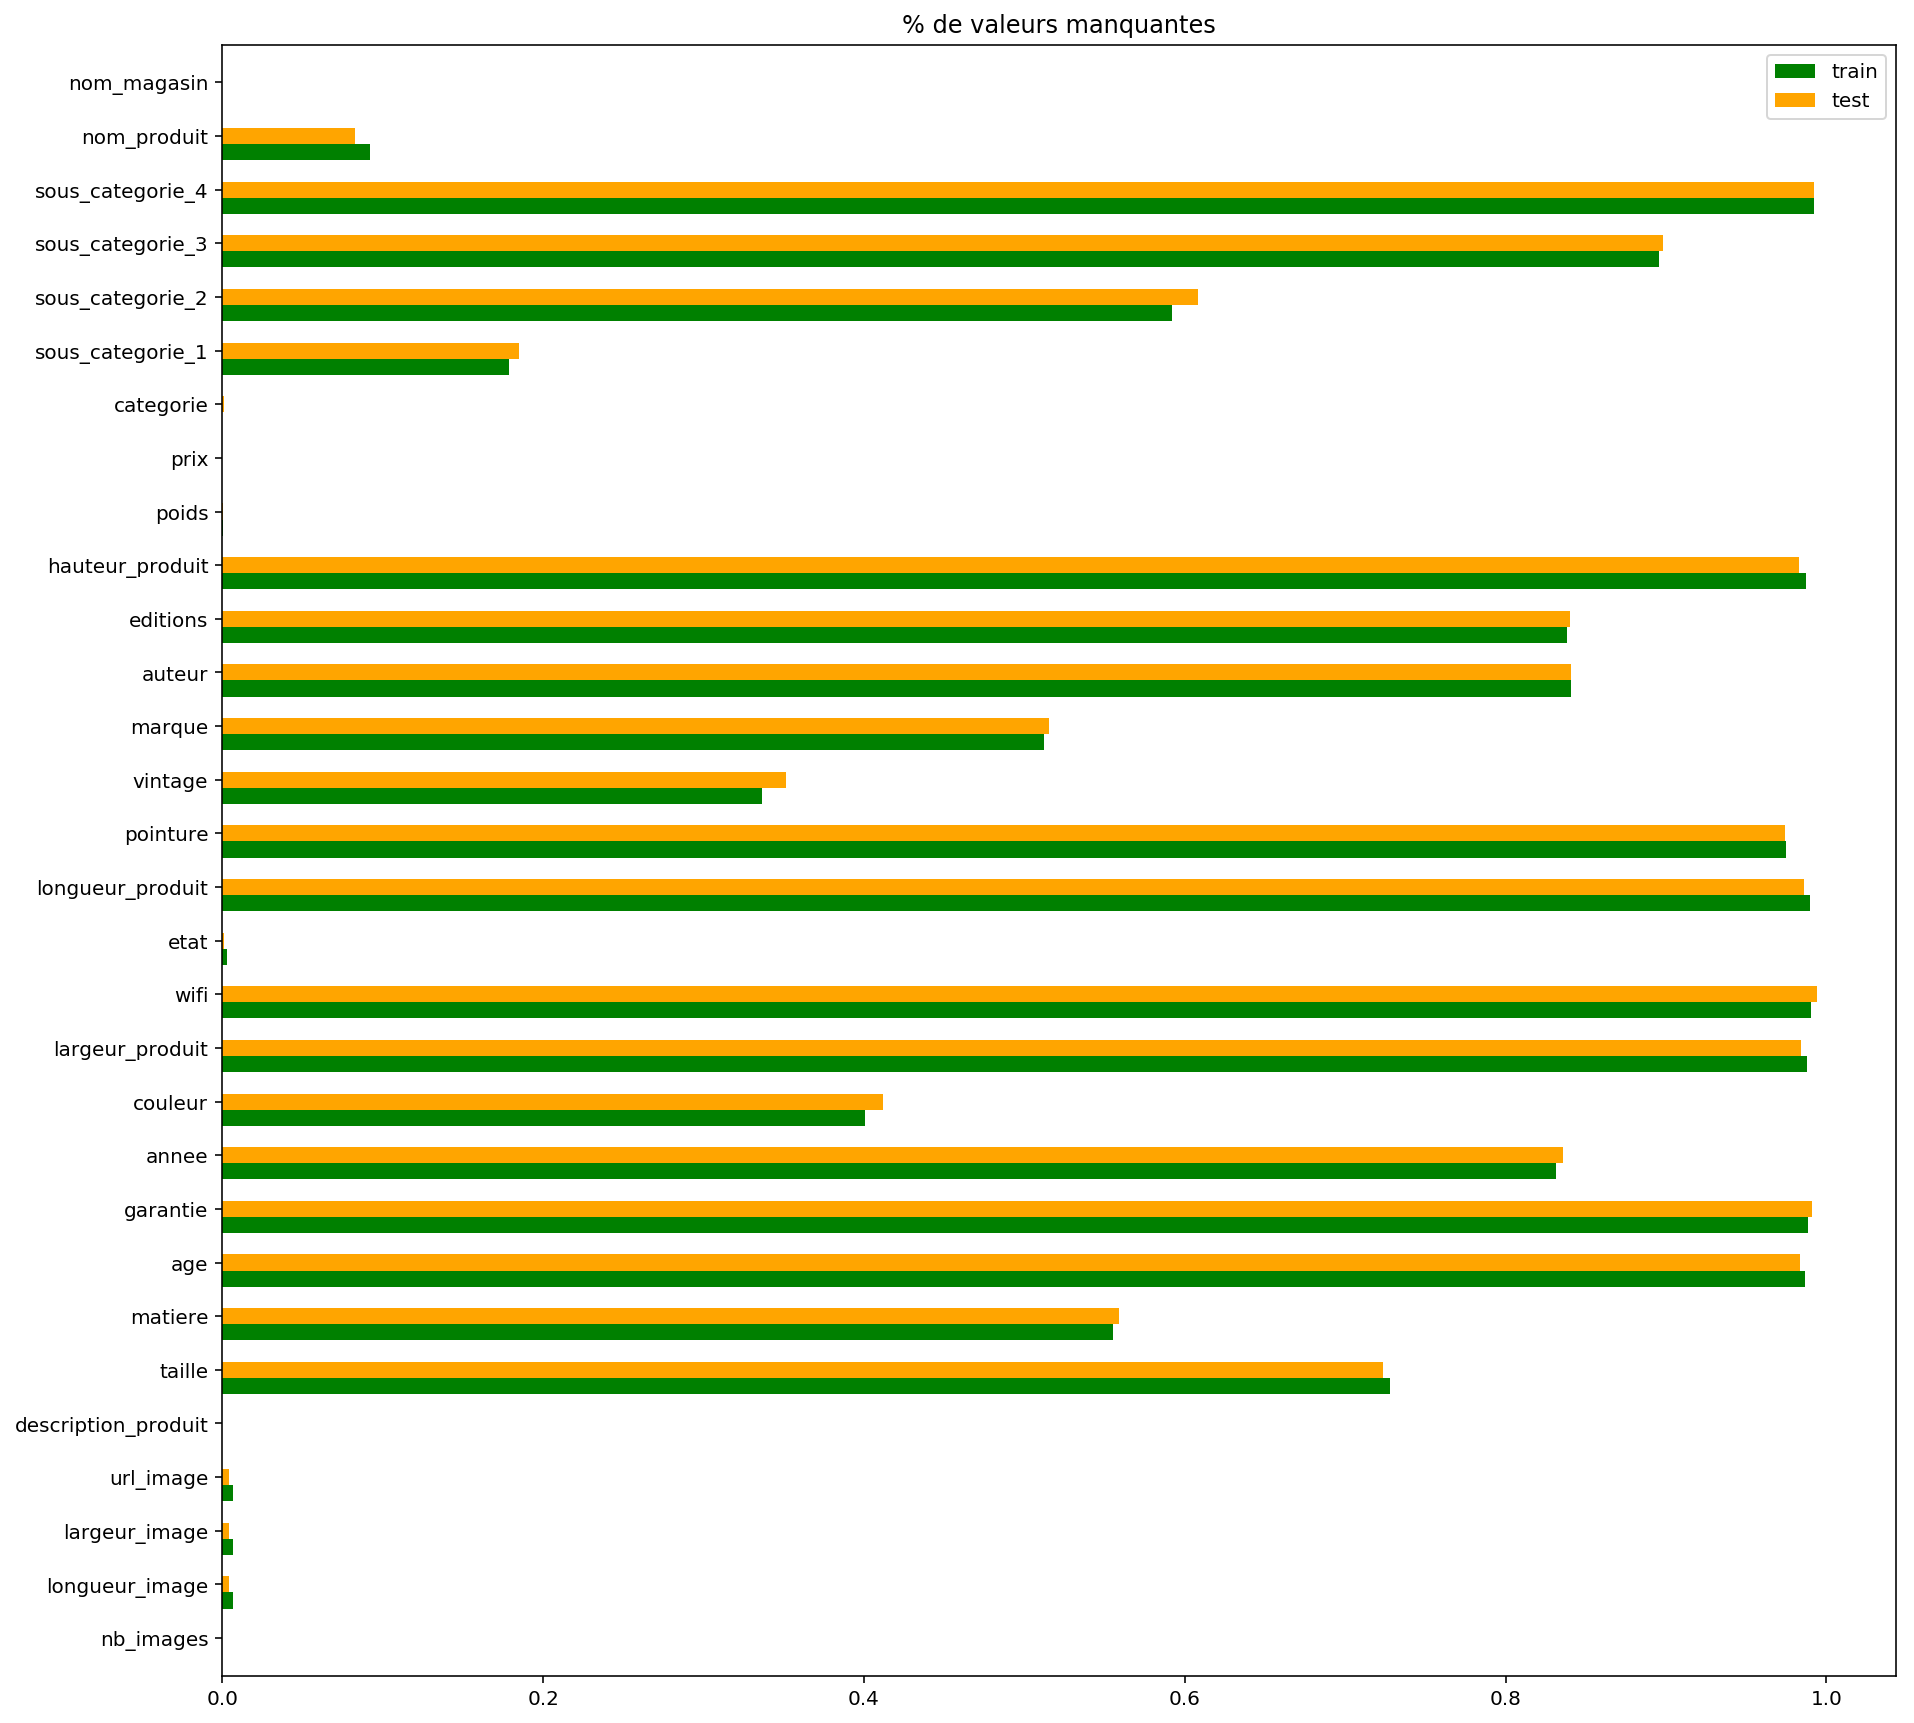

In [10]:
# Même proportion de valeur manquante par feature entre train et test
ind = np.arange(X_train.shape[1])
width = 0.3
fig, ax = plt.subplots(figsize=(15,15))
ax.barh(ind, X_train.isna().sum() / len(X_train), width, color='green', label='train')
ax.barh(ind + width, X_test.isna().sum() / len(X_test), width, color='orange', label='test')
ax.set(yticks=ind + width, yticklabels=X_train.isna().sum().index, ylim=[2*width - 1, X_train.shape[1]])
ax.legend()
plt.title('% de valeurs manquantes')
plt.show()

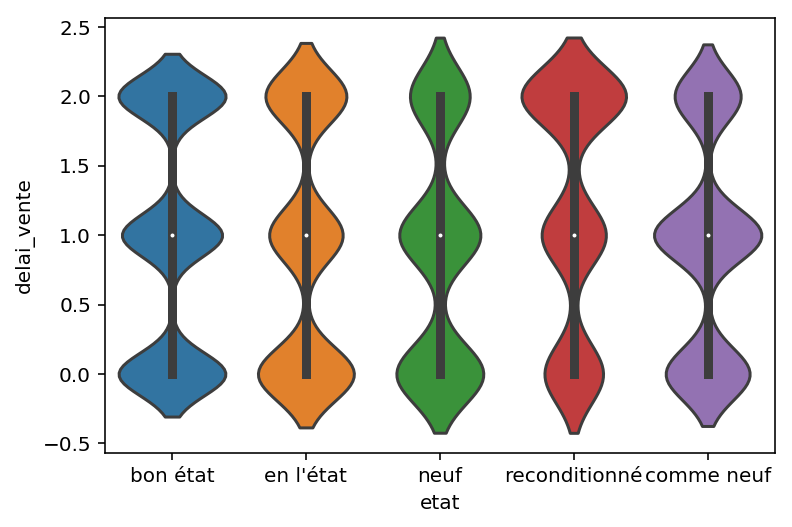

In [11]:
# Influence des variables sur y
sns.violinplot(y=y_train.delai_vente, x=X_train.etat);

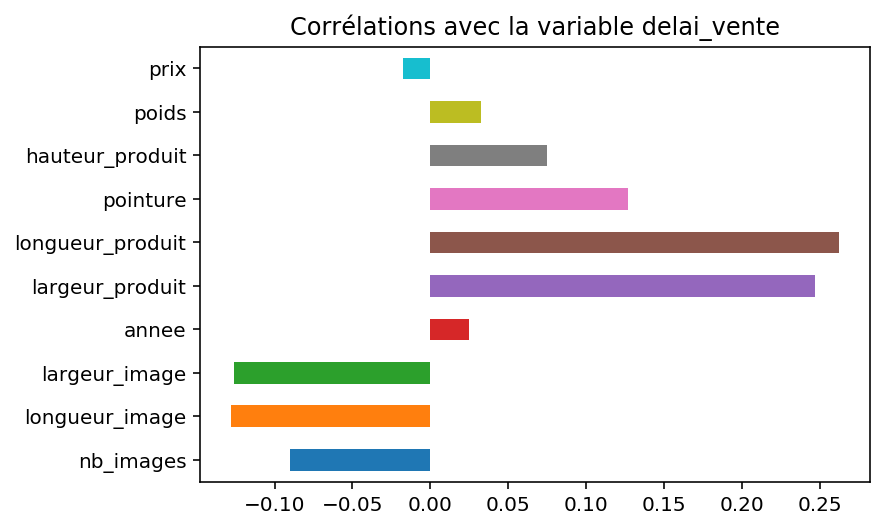

In [12]:
X_train.join(y_train).corr().delai_vente[:10].plot(kind="barh")
plt.title('Corrélations avec la variable delai_vente');

# Feature engineering

In [13]:
# On rassemble pour le feature engineering
df = pd.concat([X_train, X_test])
df = df.drop(to_be_drop_features, 1)
df.head(2)

,nb_images,longueur_image,largeur_image,description_produit,taille,matiere,age,garantie,annee,couleur,largeur_produit,wifi,etat,longueur_produit,pointure,vintage,marque,auteur,editions,hauteur_produit,poids,prix,categorie,sous_categorie_1,sous_categorie_2,sous_categorie_3,sous_categorie_4,nom_produit,nom_magasin
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3,3458.0,2552.0,Superbe petit top bustier avec explosion de co...,44,100 % polyester,NaN,NaN,NaN,Multicolore,NaN,NaN,bon état,NaN,NaN,False,NaN,NaN,NaN,NaN,200.0,4.5,mode,"tops, t-shirts, débardeurs femme",NaN,NaN,NaN,Top bustier multicolore,Emmaüs 88 Neufchateau
1,2,2486.0,2254.0,"Radio ITT Océnic Flirt, année 70\nPour déco",NaN,Plastique,NaN,NaN,NaN,Jaune,NaN,NaN,en l'état,NaN,NaN,True,ITT Océanic,NaN,NaN,NaN,1000.0,15.0,mobilier - deco,bibelots et objets déco,NaN,NaN,NaN,Radio ITT Océanic,Communauté Emmaüs Thouars (magasin Parthenay)


### Création de features

In [14]:
# Nombre de lettre des variables de texte
for col in text_features:
    print(col)
    df[f'len_char_{col}'] = df[col].astype(str).map(len)

matiere
description_produit
nom_produit


In [15]:
# Moyenne de prix par délai


In [16]:
df = df.drop(text_features, 1)
df.head(2)

,nb_images,longueur_image,largeur_image,taille,age,garantie,annee,couleur,largeur_produit,wifi,etat,longueur_produit,pointure,vintage,marque,auteur,editions,hauteur_produit,poids,prix,categorie,sous_categorie_1,sous_categorie_2,sous_categorie_3,sous_categorie_4,nom_magasin,len_char_matiere,len_char_description_produit,len_char_nom_produit
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3,3458.0,2552.0,44,NaN,NaN,NaN,Multicolore,NaN,NaN,bon état,NaN,NaN,False,NaN,NaN,NaN,NaN,200.0,4.5,mode,"tops, t-shirts, débardeurs femme",NaN,NaN,NaN,Emmaüs 88 Neufchateau,16,191,24
1,2,2486.0,2254.0,NaN,NaN,NaN,NaN,Jaune,NaN,NaN,en l'état,NaN,NaN,True,ITT Océanic,NaN,NaN,NaN,1000.0,15.0,mobilier - deco,bibelots et objets déco,NaN,NaN,NaN,Communauté Emmaüs Thouars (magasin Parthenay),9,42,17


### Imputation des valeurs manquantes

### Encodage des variables non numériques

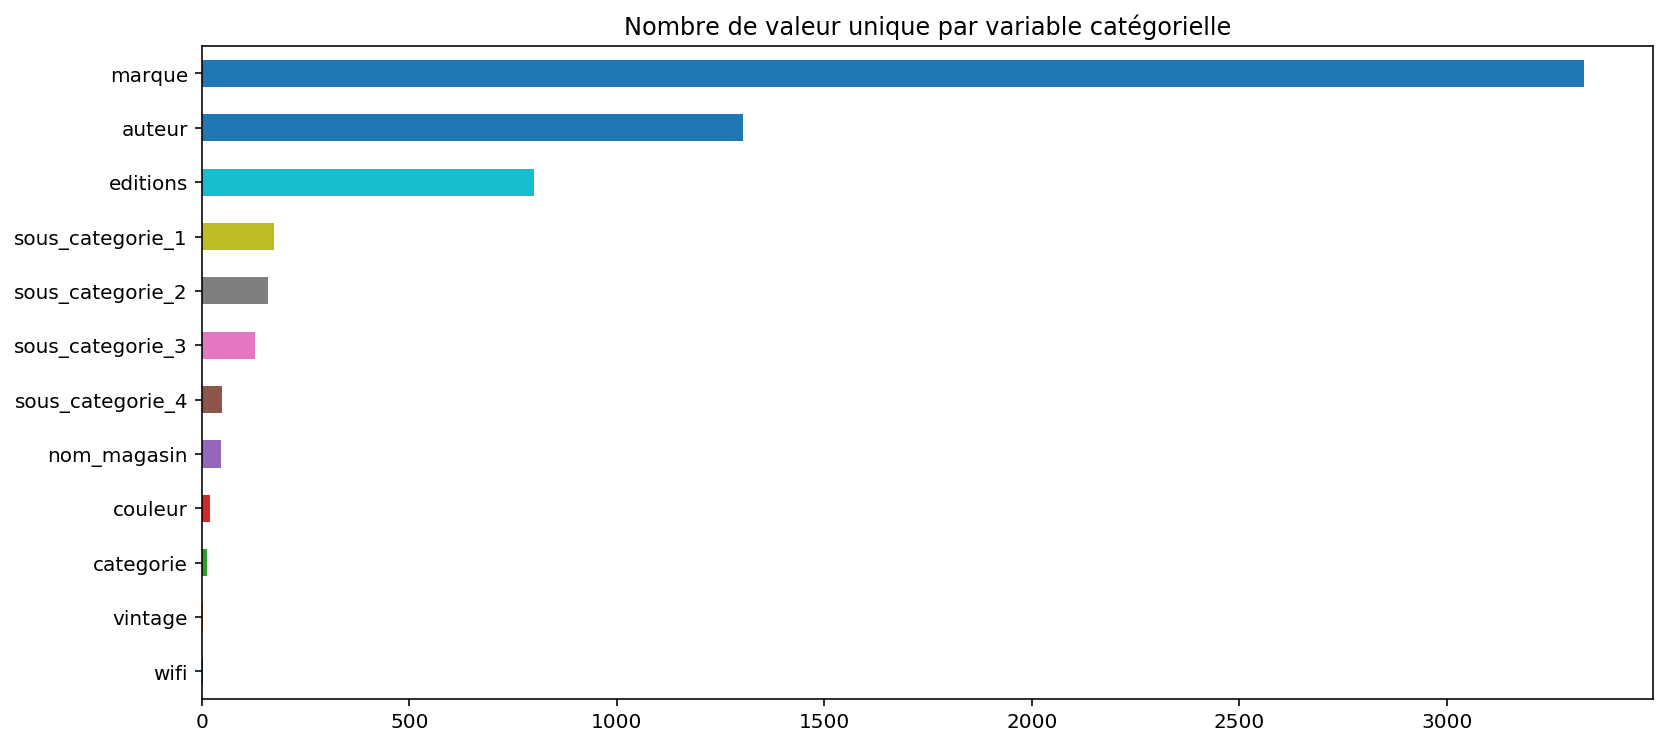

In [17]:
unique_by_feature = pd.DataFrame({col: len(df[col].unique()) for col in categorical_features}, index=[0]).T
unique_by_feature[0].sort_values(ascending=True).plot(kind="barh", figsize=(13,6))
plt.title('Nombre de valeur unique par variable catégorielle');

In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in binary_and_ordinal_features:
    df[col] = le.fit_transform(df[col].astype(str))
for col in categorical_features:
    df[col] = le.fit_transform(df[col].astype(str))

In [19]:
df.sample(3)

,nb_images,longueur_image,largeur_image,taille,age,garantie,annee,couleur,largeur_produit,wifi,etat,longueur_produit,pointure,vintage,marque,auteur,editions,hauteur_produit,poids,prix,categorie,sous_categorie_1,sous_categorie_2,sous_categorie_3,sous_categorie_4,nom_magasin,len_char_matiere,len_char_description_produit,len_char_nom_produit
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1486,1,3072.0,4608.0,33,18,2,1969.0,10,NaN,2,2,NaN,NaN,1,2499,1289,788,NaN,260.0,50.0,6,159,117,96,36,26,3,114,47
6479,2,1100.0,1100.0,33,18,2,1988.0,18,NaN,2,0,NaN,NaN,2,3262,545,113,NaN,700.0,13.0,6,98,1,3,36,23,3,149,47
6980,2,1920.0,1920.0,33,18,2,1995.0,0,NaN,2,2,NaN,NaN,0,1276,1289,788,NaN,0.4,10.0,6,2,117,96,36,7,3,287,31


### Séparation de X_train et X_test

In [20]:
df_train = df[:X_train.shape[0]]
df_test = df[(df.shape[0] - X_test.shape[0]):]

# Création du modèle

- Choose a relatively high learning rate (0.1). Determine the optimum number of trees for this learning rate.
- Tune tree-specific parameters (max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees.
- Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.
- Lower the learning rate and decide the optimal parameters .

In [21]:
from xgboost import XGBClassifier, plot_importance, cv, DMatrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.metrics import log_loss

In [22]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
X_train_eval, X_eval, y_train_eval, y_eval = train_test_split(df_train, y_train, test_size=0.33, random_state=6)

xgb_eval = XGBClassifier(max_depth=8,
                         learning_rate=0.01,
                         n_estimators=1000,
                         n_jobs=-1,
                         objective='multi:softmax',
                         gamma=0.3,
                         min_child_weight=7,
                         max_delta_step=0,
                         subsample=0.9,
                         colsample_bytree=0.6,
                         colsample_bylevel=1,
                         reg_alpha=0,
                         reg_lambda=1,
                         scale_pos_weight=1,
                         base_score=0.5,
                         random_state=42,
                         missing=None)

xgb_eval.fit(X_train_eval,
             np.ravel(y_train_eval),
             eval_set=[(X_eval, np.ravel(y_eval))],
             eval_metric='mlogloss',
             early_stopping_rounds=50,
             verbose=True);

[0]	validation_0-mlogloss:1.09749
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[1]	validation_0-mlogloss:1.09613
[2]	validation_0-mlogloss:1.09457
[3]	validation_0-mlogloss:1.09325
[4]	validation_0-mlogloss:1.09201
[5]	validation_0-mlogloss:1.09062
[6]	validation_0-mlogloss:1.08942
[7]	validation_0-mlogloss:1.08832
[8]	validation_0-mlogloss:1.08733
[9]	validation_0-mlogloss:1.08629
[10]	validation_0-mlogloss:1.08515
[11]	validation_0-mlogloss:1.08389
[12]	validation_0-mlogloss:1.08263
[13]	validation_0-mlogloss:1.08136
[14]	validation_0-mlogloss:1.08048
[15]	validation_0-mlogloss:1.07936
[16]	validation_0-mlogloss:1.07832
[17]	validation_0-mlogloss:1.07724
[18]	validation_0-mlogloss:1.07624
[19]	validation_0-mlogloss:1.07504
[20]	validation_0-mlogloss:1.07402
[21]	validation_0-mlogloss:1.07305
[22]	validation_0-mlogloss:1.07211
[23]	validation_0-mlogloss:1.07111
[24]	validation_0-mlogloss:1.07008
[25]	validation_0-mlogloss:1.06902
[26]	validation_0-mlogloss:1.06

[227]	validation_0-mlogloss:0.980158
[228]	validation_0-mlogloss:0.979989
[229]	validation_0-mlogloss:0.979831
[230]	validation_0-mlogloss:0.979675
[231]	validation_0-mlogloss:0.979537
[232]	validation_0-mlogloss:0.979363
[233]	validation_0-mlogloss:0.979192
[234]	validation_0-mlogloss:0.979025
[235]	validation_0-mlogloss:0.978866
[236]	validation_0-mlogloss:0.978708
[237]	validation_0-mlogloss:0.97852
[238]	validation_0-mlogloss:0.978327
[239]	validation_0-mlogloss:0.978215
[240]	validation_0-mlogloss:0.978119
[241]	validation_0-mlogloss:0.97798
[242]	validation_0-mlogloss:0.977876
[243]	validation_0-mlogloss:0.977765
[244]	validation_0-mlogloss:0.977589
[245]	validation_0-mlogloss:0.977443
[246]	validation_0-mlogloss:0.977395
[247]	validation_0-mlogloss:0.977265
[248]	validation_0-mlogloss:0.977185
[249]	validation_0-mlogloss:0.977021
[250]	validation_0-mlogloss:0.976932
[251]	validation_0-mlogloss:0.976855
[252]	validation_0-mlogloss:0.976631
[253]	validation_0-mlogloss:0.976523
[25

[450]	validation_0-mlogloss:0.962052
[451]	validation_0-mlogloss:0.962069
[452]	validation_0-mlogloss:0.96202
[453]	validation_0-mlogloss:0.961945
[454]	validation_0-mlogloss:0.961861
[455]	validation_0-mlogloss:0.96179
[456]	validation_0-mlogloss:0.961801
[457]	validation_0-mlogloss:0.961746
[458]	validation_0-mlogloss:0.96173
[459]	validation_0-mlogloss:0.961687
[460]	validation_0-mlogloss:0.961648
[461]	validation_0-mlogloss:0.96159
[462]	validation_0-mlogloss:0.961577
[463]	validation_0-mlogloss:0.961564
[464]	validation_0-mlogloss:0.961511
[465]	validation_0-mlogloss:0.961498
[466]	validation_0-mlogloss:0.961463
[467]	validation_0-mlogloss:0.961428
[468]	validation_0-mlogloss:0.961422
[469]	validation_0-mlogloss:0.961363
[470]	validation_0-mlogloss:0.961328
[471]	validation_0-mlogloss:0.961279
[472]	validation_0-mlogloss:0.961222
[473]	validation_0-mlogloss:0.961152
[474]	validation_0-mlogloss:0.961084
[475]	validation_0-mlogloss:0.961064
[476]	validation_0-mlogloss:0.961013
[477]

[673]	validation_0-mlogloss:0.955924
[674]	validation_0-mlogloss:0.955938
[675]	validation_0-mlogloss:0.9559
[676]	validation_0-mlogloss:0.955876
[677]	validation_0-mlogloss:0.955881
[678]	validation_0-mlogloss:0.95592
[679]	validation_0-mlogloss:0.955959
[680]	validation_0-mlogloss:0.955948
[681]	validation_0-mlogloss:0.955983
[682]	validation_0-mlogloss:0.955937
[683]	validation_0-mlogloss:0.955892
[684]	validation_0-mlogloss:0.955899
[685]	validation_0-mlogloss:0.955905
[686]	validation_0-mlogloss:0.955892
[687]	validation_0-mlogloss:0.955879
[688]	validation_0-mlogloss:0.955876
[689]	validation_0-mlogloss:0.955818
[690]	validation_0-mlogloss:0.9558
[691]	validation_0-mlogloss:0.955775
[692]	validation_0-mlogloss:0.955749
[693]	validation_0-mlogloss:0.955675
[694]	validation_0-mlogloss:0.955662
[695]	validation_0-mlogloss:0.955661
[696]	validation_0-mlogloss:0.95566
[697]	validation_0-mlogloss:0.955654
[698]	validation_0-mlogloss:0.955643
[699]	validation_0-mlogloss:0.955633
[700]	v

[896]	validation_0-mlogloss:0.954305
[897]	validation_0-mlogloss:0.954311
[898]	validation_0-mlogloss:0.954328
[899]	validation_0-mlogloss:0.954345
[900]	validation_0-mlogloss:0.954324
[901]	validation_0-mlogloss:0.954371
Stopping. Best iteration:
[851]	validation_0-mlogloss:0.95422



### Tuning des paramètres

In [45]:
%%time
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

xgb_params = {
    'base_score': 0.5,
    'colsample_bylevel': 1,
    'colsample_bytree': 0.6,
    'gamma': 0.3,
    'learning_rate': 0.1,
    'max_delta_step': 0,
    'max_depth': 8,
    'min_child_weight': 7,
    'n_estimators': 118,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'scale_pos_weight': 1,
    'subsample': 0.9,
}
param_test = {
    'reg_alpha': [0]
}
gsearch = GridSearchCV(
    estimator = XGBClassifier(**xgb_params), 
    param_grid = param_test, 
    scoring='neg_log_loss',
    n_jobs=-1,
    iid=False,
    cv=5
)
gsearch.fit(df_train, np.ravel(y_train))

CPU times: user 12.9 s, sys: 193 ms, total: 13.1 s
Wall time: 15.4 s


In [46]:
gsearch.best_params_, -gsearch.best_score_

({'reg_alpha': 0}, 0.9364094948338119)

### Calcul de l'erreur

In [139]:
xgb_params = xgb_eval.get_xgb_params()
xgb_params['n_estimators'] = xgb_eval.best_iteration
xgb = XGBClassifier(**xgb_params)
xgb.fit(df_train, np.ravel(y_train))
pred_train = xgb.predict_proba(df_train)
pred_cv = cross_val_predict(xgb, df_train, np.ravel(y_train), method='predict_proba', cv=5, n_jobs=-1)

LogLoss sur X_train: 0.7064139255528078
LogLoss sur echantillon X_train (CV): 0.9453098556379209


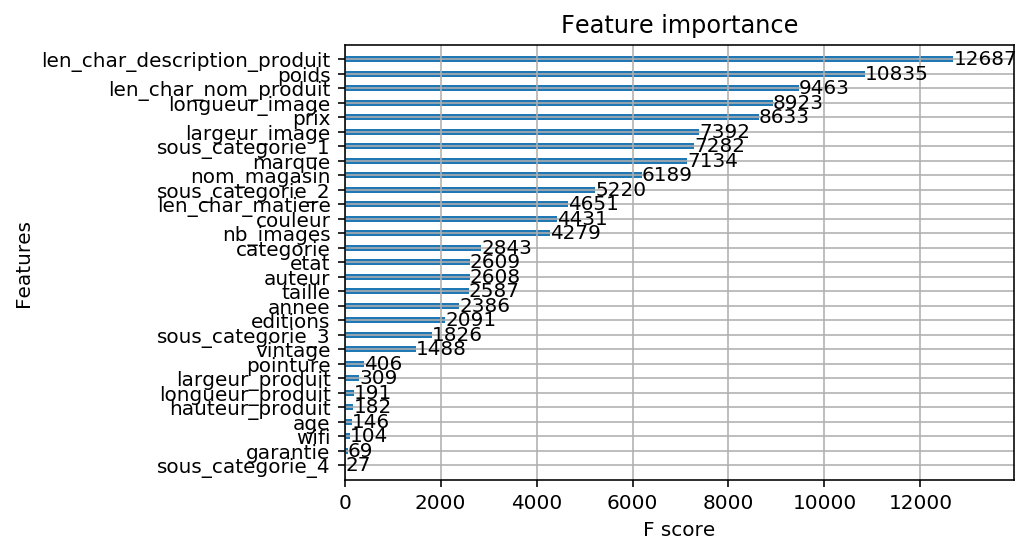

In [140]:
print('LogLoss sur X_train:', log_loss(y_pred=pred_train, y_true=y_train))
print('LogLoss sur echantillon X_train (CV):', log_loss(y_pred=pred_cv, y_true=y_train))
plot_importance(xgb_eval, height=0.4);

### Calcul des predictions

In [164]:
pred_test = xgb.predict_proba(df_test)
df_submission = pd.DataFrame(pred_test, index=X_test.index)

# Soumission

1. Aller sur la plateforme [QScore](https://qscore.meilleurdatascientistdefrance.com) puis dans "Submissions" > "Submit with a file"
2. Déposer le fichier CSV

In [165]:
df_submission.to_csv('my_prediction.csv', index_label='id', header=['0', '1', '2'])

# Reste à essayer

- ajouter pleins de vari agg/mean/tfidf puis feature selaction
- bayesian pymc3 https://eigenfoo.xyz/bayesian-modelling-cookbook/
- https://github.com/WillKoehrsen/feature-selector
- https://github.com/WillKoehrsen/automated-feature-engineering/blob/master/walk_through/Automated_Feature_Engineering.ipynb

Faire un label encoding en respectant l'ordre / dummification de var catég

Essayer diff méthodes de fillna pour pointure / wifi / auteur / editions / garantie (valeur autres) / ceux qui ont bcp de na

Attention outliers poids/prix

hyperopt https://www.dataiku.com/learn/guide/code/python/advanced-xgboost-tuning.html

# Possibilité de soumission via l'API de QScore

1. Aller sur la plateforme [QScore](https://qscore.meilleurdatascientistdefrance.com) puis dans "Submissions" > "Submit from your Python Notebook"
2. Récuperer votre TOKEN
3. Le remplacer dans la fonction ci-dessous et l'exécuter

In [121]:
import io, math, requests

def submit_prediction(df, sep=',', **kwargs):
    # TOKEN a recuperer sur la plateforme: "Submissions" > "Submit from your Python Notebook"
    TOKEN='696446f49b2303e608bdeda76cfcd5ac78ea58f60d304f88dfa88c80a0f9d96d68795b637bbc62b6daa56e04f4e3e6262b81354e5bd500fd0ac002b3c83f26d1'  
    URL='https://qscore.meilleurdatascientistdefrance.com/api/submissions'
    buffer = io.StringIO()
    df.to_csv(buffer, sep=sep, **kwargs)
    buffer.seek(0)
    r = requests.post(URL, headers={'Authorization': 'Bearer {}'.format(TOKEN)},files={'datafile': buffer})
    if r.status_code == 429:
        raise Exception('Submissions are too close. Next submission is only allowed in {} seconds.'.format(int(math.ceil(int(r.headers['x-rate-limit-remaining']) / 1000.0))))
    if r.status_code != 200:
        raise Exception(r.text)